In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import integrate
import sys


sys.path.insert(0, '../src')
sys.path.insert(0, '../Data')

# sys.path.append("./data")
# sys.path.append("./src")

import model 
import matrix
import plot
import os
import operator
import seaborn as sns

In [2]:
path = "../Data"
metaFile = "filtered_hmp2_metadata.tsv"
taxFile = "taxonomic_profiles.tsv"

metaData = pd.read_csv(os.path.join(path, metaFile), sep='\t', header=0)
taxData = pd.read_csv(os.path.join(path, taxFile), sep='\t', header=0)

print(metaData.shape)
metaData.head()

(174, 87)


,Project,External ID,Participant ID,site_sub_coll,data_type,week_num,visit_num,Research Project,IntervalName,IntervalSequence,...,Did the subject withdraw from the study?,Was subject terminated by investigator?,Partial Endoscopy,race,Arthralgias,Pyoderma gangrenosum.1,Erythema nodosum.1,Uveitis.1,Partial Endoscopy.1,sex
0,C3001CSC1_BP,206615,C3001,C3001CSC1,biopsy_16S,2.0,1,ibdmdb,Screening Colonoscopy,1,...,No,No,No,White,No,No,No,No,No,Female
1,C3001CSC2_BP,206614,C3001,C3001CSC2,biopsy_16S,2.0,1,ibdmdb,Screening Colonoscopy,1,...,No,No,No,White,No,No,No,No,No,Female
2,C3002CSC1_BP,206617,C3002,C3002CSC1,biopsy_16S,0.0,1,ibdmdb,Screening Colonoscopy,1,...,No,No,No,White,No,No,No,No,No,Female
3,C3002CSC2_BP,206619,C3002,C3002CSC2,biopsy_16S,0.0,1,ibdmdb,Screening Colonoscopy,1,...,No,No,No,White,No,No,No,No,No,Female
4,C3002CSC3_BP,206616,C3002,C3002CSC3,biopsy_16S,0.0,1,ibdmdb,Screening Colonoscopy,1,...,No,No,No,White,No,No,No,No,No,Female


In [3]:
print(taxData.shape)
taxData.head()

(982, 180)


,#OTU ID,206646,224324,206619,224326,206624,219644,214995,215058,206750,...,215003,206628,219675,206728,206754,206718,206657,206670,206655,taxonomy
0,IP8BSoli,0.0,0.0,0.0,0.0,17.0,0.0,0.0,0.0,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Bacteria; __Proteobacteria; __Alphaproteobacte...
1,UncTepi3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,2.0,0.0,0.0,0.0,0.0,10.0,0.0,Bacteria; __Proteobacteria; __Betaproteobacter...
2,Unc004ii,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,36.0,Bacteria; __Firmicutes; __Clostridia; __Clostr...
3,Unc00re8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,2.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,Bacteria; __Bacteroidetes; __Bacteroidia; __Ba...
4,Unc018j2,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,25.0,Bacteria; __Firmicutes; __Clostridia; __Clostr...


# Obtaining the List of Unique Diagnoses 

In [4]:
diagList = list(metaData.diagnosis.unique())
IDs = dict.fromkeys(diagList,[])

for diag in diagList:
    IDs[diag] = metaData.loc[metaData.diagnosis == diag]["External ID"].astype(str)


In [5]:
#Averages each strain abundance by the number of occurences of that strain and returns the total abundance
def Average_Abundance(strainAbund,strainCount):
    totAbund = 0.0
    
    for strain in strainAbund:
        
        #Deletes key,value pairs for strains with zero count
        if strainCount[strain] == 0:
            del strainCount[strain]
            del strainAbund[strain]
            
        else:    
            strainAbund[strain] /= strainCount[strain]
            totAbund += strainAbund[strain]
        
    return totAbund

In [6]:
def Normalize_Abundances(strainAbund,totAbund):
    
    for strain in strainAbund:
        strainAbund[strain] /= totAbund

In [7]:
#Obtain the average abundance of each bacteria strain present across all participants with the same diagnosis
#Takes as input a list of ids of patients all with the same diagnosis as well as the complete taxonomic data for
#all participants
def Get_Strain_Abundances(idList,taxData):
    strainAbund = {}
    strainCount = dict.fromkeys(taxData["#OTU ID"].unique(),0)
    
    #Iterate over participants with specific diagnosis
    for id in idList[0:1]:
        
        #Find bacteria with non-zero abundance 
        nonZero = taxData.loc[taxData[id] != 0.0][["#OTU ID",id]] 
        nonZero["#OTU ID"].astype(str)
        
        #Convert to numpy
        strainList = nonZero["#OTU ID"].to_numpy()
        AbundList = nonZero[id].to_numpy()
        #strainCount = dict.fromkeys(strainList,0)
        
        for i,strain in enumerate(strainList):
           
            if strain in strainAbund.keys():
                strainAbund[strain] += AbundList[i]
                strainCount[strain] += 1
            
            else:
                strainAbund[strain] = AbundList[i]
                strainCount[strain] += 1
    
    
    totAbund = Average_Abundance(strainAbund,strainCount)
        
    return strainAbund,totAbund

# Applying Different Matrix Types for Each Diagnosis Dataset

QS interaction matrix
(62, 62)
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
simulating...
finished simulating!
plotting...


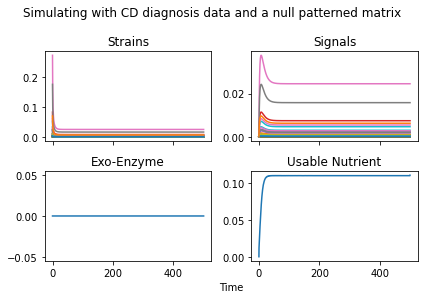

QS interaction matrix
(11, 11)
[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]
simulating...
finished simulating!
plotting...


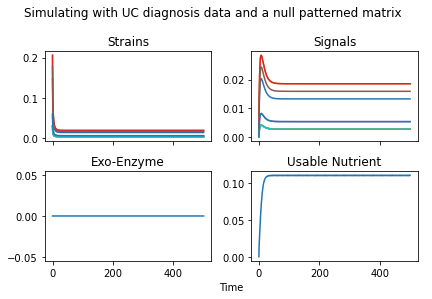

QS interaction matrix
(133, 133)
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
simulating...
finished simulating!
plotting...


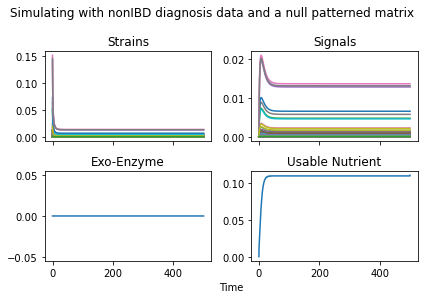

QS interaction matrix
(62, 62)
[[1 0 0 ... 0 0 0]
 [0 1 0 ... 0 0 0]
 [0 0 1 ... 0 0 0]
 ...
 [0 0 0 ... 1 0 0]
 [0 0 0 ... 0 1 0]
 [0 0 0 ... 0 0 1]]
simulating...
finished simulating!
plotting...


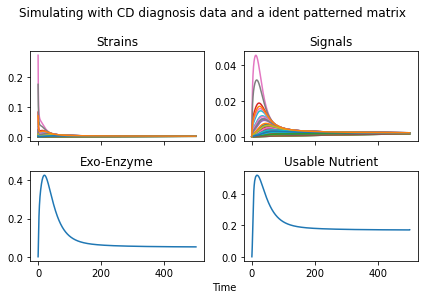

QS interaction matrix
(11, 11)
[[1 0 0 0 0 0 0 0 0 0 0]
 [0 1 0 0 0 0 0 0 0 0 0]
 [0 0 1 0 0 0 0 0 0 0 0]
 [0 0 0 1 0 0 0 0 0 0 0]
 [0 0 0 0 1 0 0 0 0 0 0]
 [0 0 0 0 0 1 0 0 0 0 0]
 [0 0 0 0 0 0 1 0 0 0 0]
 [0 0 0 0 0 0 0 1 0 0 0]
 [0 0 0 0 0 0 0 0 1 0 0]
 [0 0 0 0 0 0 0 0 0 1 0]
 [0 0 0 0 0 0 0 0 0 0 1]]
simulating...
finished simulating!
plotting...


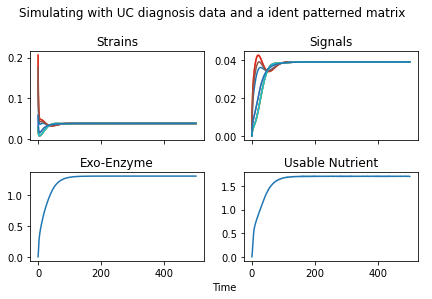

QS interaction matrix
(133, 133)
[[1 0 0 ... 0 0 0]
 [0 1 0 ... 0 0 0]
 [0 0 1 ... 0 0 0]
 ...
 [0 0 0 ... 1 0 0]
 [0 0 0 ... 0 1 0]
 [0 0 0 ... 0 0 1]]
simulating...
finished simulating!
plotting...


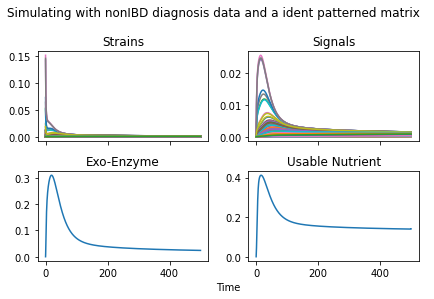

QS interaction matrix
(62, 62)
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
simulating...
finished simulating!
plotting...


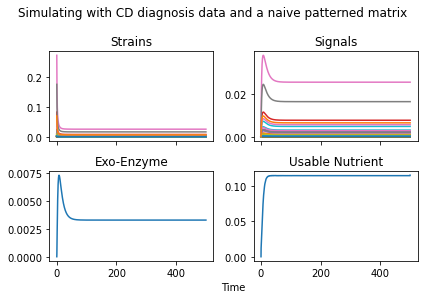

QS interaction matrix
(11, 11)
[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]
simulating...
finished simulating!
plotting...


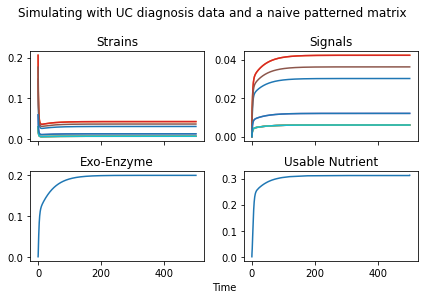

QS interaction matrix
(133, 133)
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
simulating...
finished simulating!
plotting...


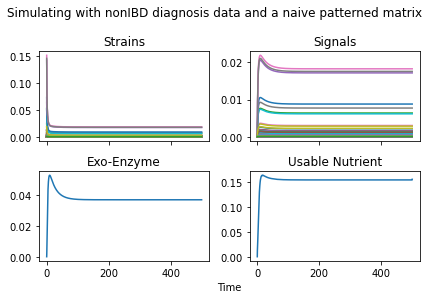

QS interaction matrix
(62, 62)
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
simulating...
finished simulating!
plotting...


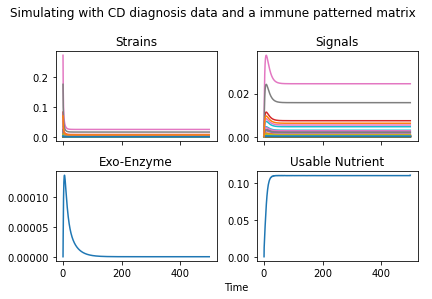

QS interaction matrix
(11, 11)
[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]]
simulating...
finished simulating!
plotting...


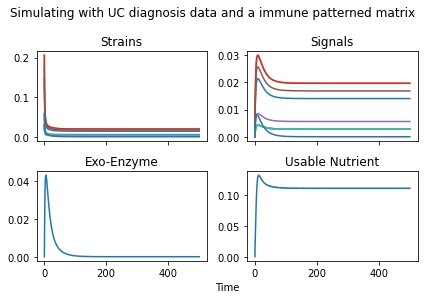

QS interaction matrix
(133, 133)
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
simulating...
finished simulating!
plotting...


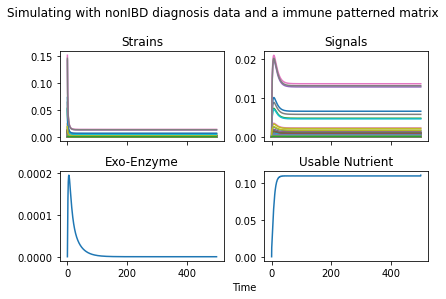

QS interaction matrix
(62, 62)
[[0 1 0 ... 0 0 1]
 [1 0 1 ... 0 0 0]
 [0 1 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 1 0]
 [0 0 0 ... 1 0 1]
 [1 0 0 ... 0 1 0]]
simulating...
finished simulating!
plotting...


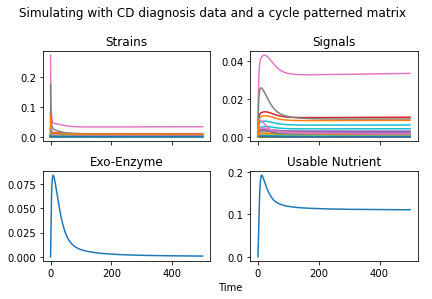

QS interaction matrix
(11, 11)
[[0 1 0 0 0 0 0 0 0 0 1]
 [1 0 1 0 0 0 0 0 0 0 0]
 [0 1 0 1 0 0 0 0 0 0 0]
 [0 0 1 0 1 0 0 0 0 0 0]
 [0 0 0 1 0 1 0 0 0 0 0]
 [0 0 0 0 1 0 1 0 0 0 0]
 [0 0 0 0 0 1 0 1 0 0 0]
 [0 0 0 0 0 0 1 0 1 0 0]
 [0 0 0 0 0 0 0 1 0 1 0]
 [0 0 0 0 0 0 0 0 1 0 1]
 [1 0 0 0 0 0 0 0 0 1 0]]
simulating...
finished simulating!
plotting...


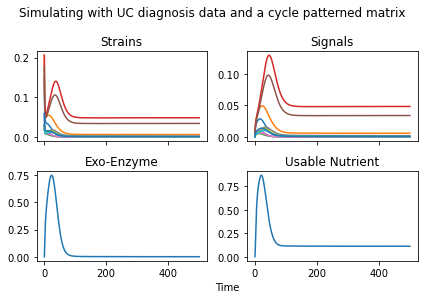

QS interaction matrix
(133, 133)
[[0 1 0 ... 0 0 1]
 [1 0 1 ... 0 0 0]
 [0 1 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 1 0]
 [0 0 0 ... 1 0 1]
 [1 0 0 ... 0 1 0]]
simulating...
finished simulating!
plotting...


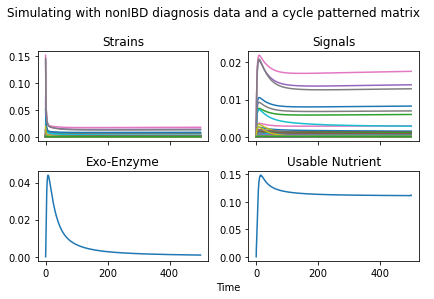

QS interaction matrix
(62, 62)
[[0 1 1 ... 1 1 1]
 [1 0 1 ... 1 1 1]
 [1 1 0 ... 1 1 1]
 ...
 [1 1 1 ... 0 1 1]
 [1 1 1 ... 1 0 1]
 [1 1 1 ... 1 1 0]]
simulating...
finished simulating!
plotting...


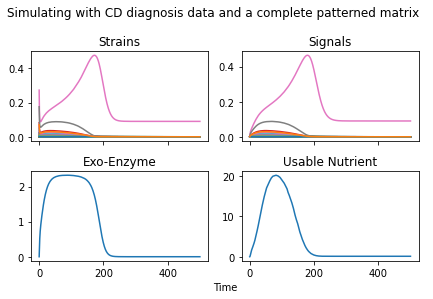

QS interaction matrix
(11, 11)
[[0 1 1 1 1 1 1 1 1 1 1]
 [1 0 1 1 1 1 1 1 1 1 1]
 [1 1 0 1 1 1 1 1 1 1 1]
 [1 1 1 0 1 1 1 1 1 1 1]
 [1 1 1 1 0 1 1 1 1 1 1]
 [1 1 1 1 1 0 1 1 1 1 1]
 [1 1 1 1 1 1 0 1 1 1 1]
 [1 1 1 1 1 1 1 0 1 1 1]
 [1 1 1 1 1 1 1 1 0 1 1]
 [1 1 1 1 1 1 1 1 1 0 1]
 [1 1 1 1 1 1 1 1 1 1 0]]
simulating...
finished simulating!
plotting...


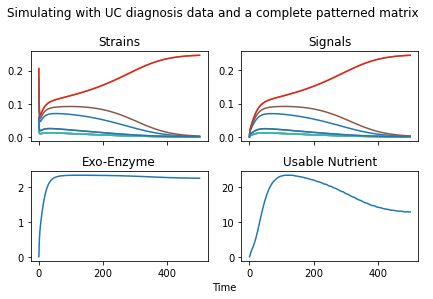

QS interaction matrix
(133, 133)
[[0 1 1 ... 1 1 1]
 [1 0 1 ... 1 1 1]
 [1 1 0 ... 1 1 1]
 ...
 [1 1 1 ... 0 1 1]
 [1 1 1 ... 1 0 1]
 [1 1 1 ... 1 1 0]]
simulating...
finished simulating!
plotting...


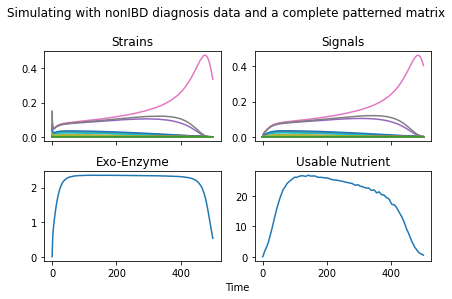

QS interaction matrix
(62, 62)
[[0 1 1 ... 1 1 1]
 [1 0 0 ... 0 0 0]
 [1 0 0 ... 0 0 0]
 ...
 [1 0 0 ... 0 0 0]
 [1 0 0 ... 0 0 0]
 [1 0 0 ... 0 0 0]]
simulating...
finished simulating!
plotting...


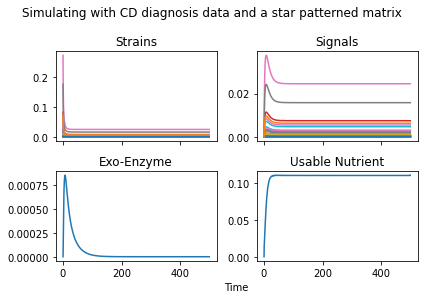

QS interaction matrix
(11, 11)
[[0 1 1 1 1 1 1 1 1 1 1]
 [1 0 0 0 0 0 0 0 0 0 0]
 [1 0 0 0 0 0 0 0 0 0 0]
 [1 0 0 0 0 0 0 0 0 0 0]
 [1 0 0 0 0 0 0 0 0 0 0]
 [1 0 0 0 0 0 0 0 0 0 0]
 [1 0 0 0 0 0 0 0 0 0 0]
 [1 0 0 0 0 0 0 0 0 0 0]
 [1 0 0 0 0 0 0 0 0 0 0]
 [1 0 0 0 0 0 0 0 0 0 0]
 [1 0 0 0 0 0 0 0 0 0 0]]
simulating...
finished simulating!
plotting...


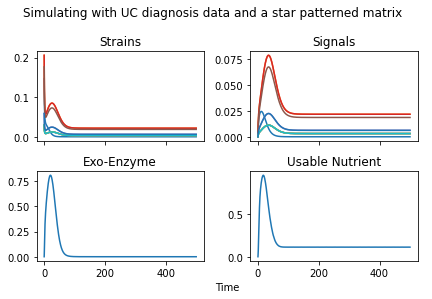

QS interaction matrix
(133, 133)
[[0 1 1 ... 1 1 1]
 [1 0 0 ... 0 0 0]
 [1 0 0 ... 0 0 0]
 ...
 [1 0 0 ... 0 0 0]
 [1 0 0 ... 0 0 0]
 [1 0 0 ... 0 0 0]]
simulating...
finished simulating!
plotting...


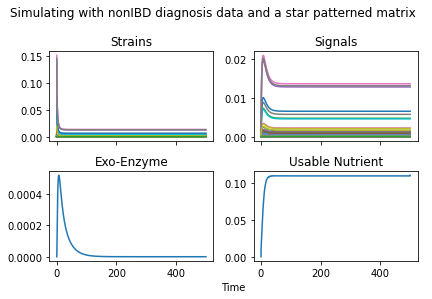

QS interaction matrix
(62, 62)
[[0 1 1 ... 0 0 0]
 [1 0 1 ... 0 0 0]
 [1 1 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 1 1]
 [0 0 0 ... 1 0 1]
 [0 0 0 ... 1 1 0]]
simulating...
finished simulating!
plotting...


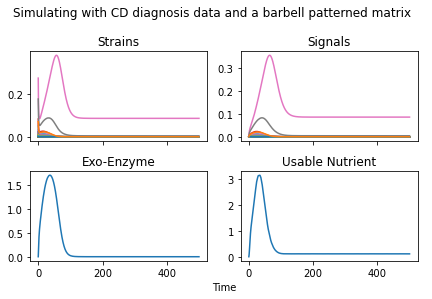

QS interaction matrix
(10, 10)
[[0 1 1 1 1 0 0 0 0 0]
 [1 0 1 1 1 0 0 0 0 0]
 [1 1 0 1 1 0 0 0 0 0]
 [1 1 1 0 1 0 0 0 0 0]
 [1 1 1 1 0 1 0 0 0 0]
 [0 0 0 0 1 0 1 1 1 1]
 [0 0 0 0 0 1 0 1 1 1]
 [0 0 0 0 0 1 1 0 1 1]
 [0 0 0 0 0 1 1 1 0 1]
 [0 0 0 0 0 1 1 1 1 0]]
simulating...
finished simulating!
plotting...


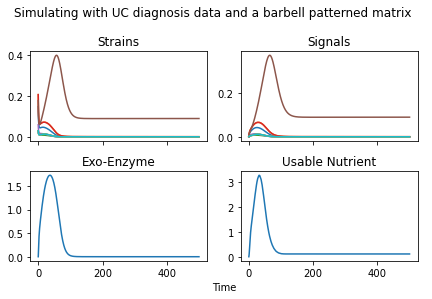

QS interaction matrix
(132, 132)
[[0 1 1 ... 0 0 0]
 [1 0 1 ... 0 0 0]
 [1 1 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 1 1]
 [0 0 0 ... 1 0 1]
 [0 0 0 ... 1 1 0]]
simulating...
finished simulating!
plotting...


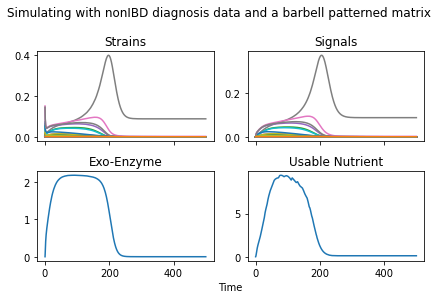

In [12]:
matrixTypes = ['null','ident','naive','immune','cycle','complete','star','barbell'] 
data = []

#Iterate over matrix types
for matType in matrixTypes:

    #Iterate over diagnoses
    for diag in diagList:
        strainAbund, totAbund = Get_Strain_Abundances(IDs[diag],taxData)
        Normalize_Abundances(strainAbund,totAbund)

        #Obtain the initial population density
        N = list(strainAbund.values())
        
        #If barbell matrix and N not even delete last list entry to make it even
        if matType == 'barbell' and len(N)%2 != 0:
            del N[-1]

        K_ac = matrix.pattern_matrix(matType,len(N))
        
        #Run sim with K_ac matrix type and seed population densities
        title = f"Simulating with {diag} diagnosis data and a {matType} patterned matrix"
        results = model.simulate(K_ac,N,500,mb=True)
        plot.run_model_mb(K_ac,N,500,title)
        

        output = {"condition": [diag]*len(results[0]),"matrix": [matType]*len(results[0]),"t":results[0],"N":np.sum(results[1],axis=0)}  
        data.append(pd.DataFrame(output))

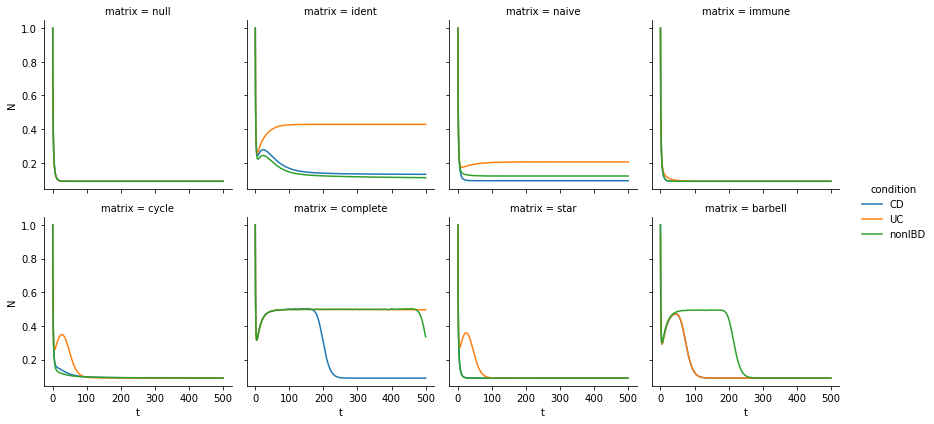

In [13]:
data = pd.concat(data)
plotFinal = sns.FacetGrid(data, col = "matrix",hue = "condition",col_wrap = 4)
plotFinal.map_dataframe(sns.lineplot, x = "t", y = "N")
plotFinal.add_legend()
plotFinal.tight_layout()
plotFinal.fig.savefig('../Documents/figures/microbiome_analysis.png')